In [1]:
# !pip install IPython
from IPython.display import Image

In [ ]:
!git clone https://github.com/Im-JihyunKim/2023_LG_ES_SSL_1.git # colab 사용시

-------

##### jupyter notebook 단축키

- ctrl+enter: 셀 실행   
- shift+enter: 셀 실행 및 다음 셀 이동   
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)

## 1. 모듈 불러오기

In [2]:
import os, random
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models

from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import transforms
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.set_cmap('cividis')
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings(action='ignore')

c:\Users\JihyunKim\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 640x480 with 0 Axes>

In [3]:
'''
seed 정의
https://hoya012.github.io/blog/reproducible_pytorch/
'''
random_seed = 2023
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 2. CIFAR10 Dataset 정의

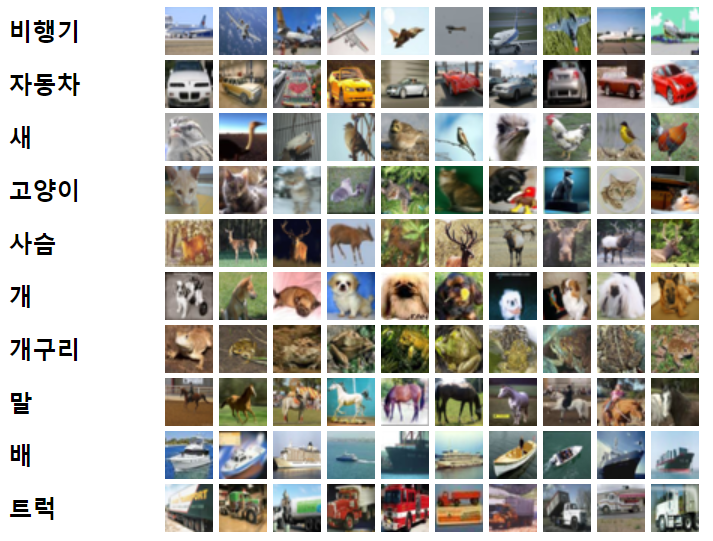

In [4]:
# Image('img/cifar10.PNG') # 로컬 사용시
Image('/content/2023_LG_ES_SSL_2/img/cifar10.PNG') # colab 사용시

- 32x32의 RGB 이미지로 구성된 데이터셋
  - 총 60,000개의 데이터가 있으며 일반적으로 50,000개는 학습용, 10,000개는 테스트용으로 구분해서 사용
- 10개의 class를 분류하는 image classification task에 주로 활용

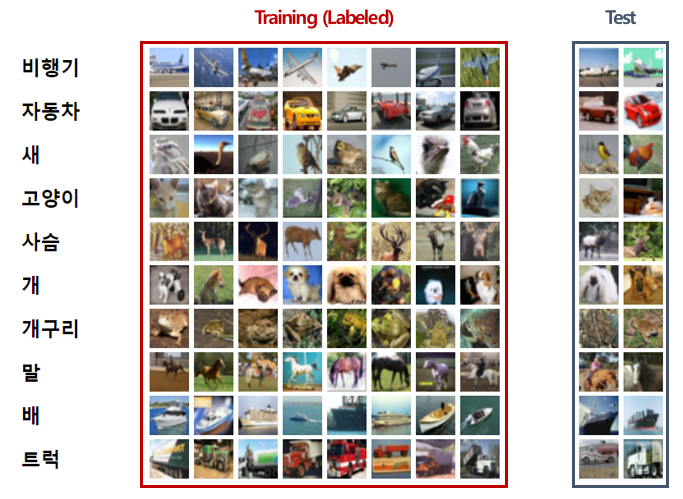

In [4]:
# Image('image/supcon_cifar.PNG') # 로컬 사용시
Image('/content/2023_LG_ES_SSL_1/image/supcon_cifar.PNG') # colab 사용시

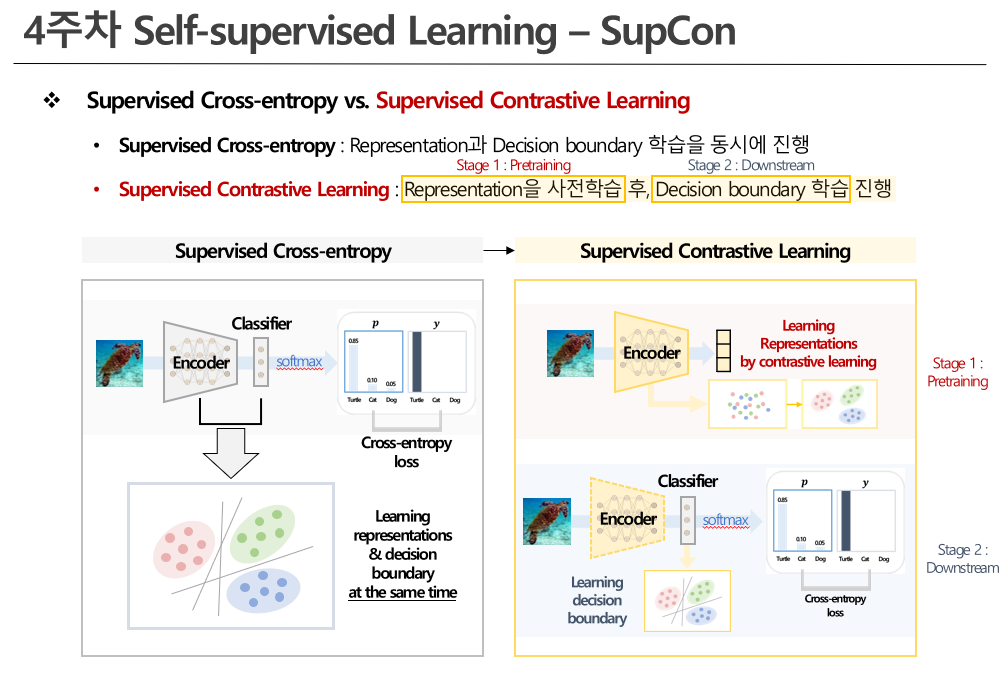

In [28]:
# Image('image/whysupcon.PNG') # 로컬 사용시
Image('/content/2023_LG_ES_SSL_1/image/whysupcon.PNG') # colab 사용시

In [10]:
# Custom Dataset
class CIFAR10Dataset(Dataset):
    def __init__(self, data_dir:str):
        self.data_dir = data_dir

        # 저장 경로 폴더가 없는 경우 만들어주어야 함
        os.makedirs(data_dir, exist_ok=True)

    # For Self-supervised Learning
    def get_pretrain_dataset(self, n_views: int=2):
        pretrain_dataset = datasets.CIFAR10(self.data_dir, 
                                            train=True,  # train 여부
                                            transform=ViewGenerator(   # 사전에 정의한 augmented images generator 기반으로 transform 수행
                                                    base_transform=self.get_transform(size=32),  # 사전에 정의한 이미지 변형 방법 적용
                                                    n_views=n_views),  # view는 하나의 동일한 이미지를 다른 시각으로 본다는 의미로, number of views 만큼 augmentation 수행
                                            download=True)
        return pretrain_dataset
    
    # For Downstream task : 지도학습에 사용되는 데이터
    def get_dataset(self, mode:str='train'):
        if mode == 'train':
            train_dataset = datasets.CIFAR10(self.data_dir,
                                            train=True,   # train 여부
                                            transform=transforms.Compose([
                                                    transforms.ToTensor(),     # 이미지를 tensor 타입으로 바꾸어줌
                                                    transforms.Normalize(      # 이미지 데이터 내의 값을 정규화 (역전파 단계에서 gradient 계산 시 데이터마다 유사한 범위의 값을 가지도록 하기 위함)
                                                            mean=(0.4914, 0.4822, 0.4465),
                                                            std=(0.2023, 0.1994, 0.2010))
                                                            ]),
                                            download=True)
            return train_dataset
        
        elif mode == 'test':
            test_dataset = datasets.CIFAR10(self.data_dir,
                                            train=False,   # train 여부
                                            transform=transforms.Compose([
                                                    transforms.ToTensor(),     # 이미지를 tensor 타입으로 바꾸어줌
                                                    transforms.Normalize(      # 이미지 데이터 내의 값을 정규화 (역전파 단계에서 gradient 계산 시 데이터마다 유사한 범위의 값을 가지도록 하기 위함)
                                                            mean=(0.4914, 0.4822, 0.4465),
                                                            std=(0.2023, 0.1994, 0.2010))
                                                            ]),
                                            download=True)
            return test_dataset

        else:
            raise NotImplementedError("'mode' should be one of ['train' or 'test']")
        
        
    @staticmethod  # 해당 클래스에서만 사용되는 메소드
    def get_transform(size: int=96, s:int=1):
        """
        Return a set of data augmentation transformations 
        as described in the SimCLR paper.
        - SImCLR에서는 augmentation에 대해서 'random crop and resize', 'color distortion', 'blur'가 결합된 augmentation이 좋은 성능을 도출한다고 설명
        """
        normalize = transforms.Normalize(      # 이미지 데이터 내의 값을 정규화 (역전파 단계에서 gradient 계산 시 데이터마다 유사한 범위의 값을 가지도록 하기 위함)
            mean=(0.4914, 0.4822, 0.4465),
            std=(0.2023, 0.1994, 0.2010)
        )
        color_jitter = transforms.ColorJitter(0.8 * s, 
                                              0.8 * s,
                                              0.8 * s,
                                              0.2 * s)
        data_transforms = transforms.Compose([
            transforms.RandomResizedCrop(size=size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=9),
            transforms.ToTensor(),  # 이미지 데이터 텐서화
            normalize,              # 앞서 정의한 이미지 정규화 수행
        ])

        return data_transforms
        
########################################################################################################################################

class ViewGenerator(object):
    """
    Take 2 ransom crops of one image as the query and key.
    """
    def __init__(self, base_transform, n_views: int=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):  # ViewGenerator 클래스 호출 시 수행되는 함수
        return [self.base_transform(x) for i in range(self.n_views)]  # n_views 만큼 base_transform(get_transform 메소드에서 정의된 증강기법)을 수행하라

# 학습 네트워크 정의

In [5]:
class ResNet(nn.Module):
    def __init__(self, base_model: str, hidden_size: int, projection_size: int):
        super(ResNet, self).__init__()

        self.resnet_dict = {
            'resnet18': models.resnet18(pretrained=False),   # ResNet layer 개수에 따라 다른 backbone 선정
            'resnet50': models.resnet50(pretrained=False)
        }

        resnet = self.get_basemodel(base_model)

        # Define CNN encoder
        self.encoder = nn.Sequential(
            *list(resnet.children())[:-1])
        
        # Define MLP Projection
        self.projection = MLPHead(in_channels=resnet.fc.in_features,
                                  mlp_hidden_size=hidden_size,
                                  projection_size=projection_size)
        
    def forward(self, x: torch.Tensor):
        h = self.encoder(x)
        h = h.view(h.shape[0], h.shape[1])
        
        return self.projection(h)
    
    def get_basemodel(self, model_name: str = None):
        
        model = self.resnet_dict[model_name]
        
        return model
    

######################################################################################################

class MLPHead(nn.Module):
    def __init__(self, 
                 in_channels: int,
                 mlp_hidden_size: int,
                 projection_size):
        super(MLPHead, self).__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, mlp_hidden_size), 
            nn.ReLU(inplace=True),
            nn.Linear(mlp_hidden_size, projection_size)
        )
    
    def forward(self, x):
        
        return self.mlp(x)

## 4. SupCon 학습 정의

### SupCon 모델 평가지표
- accuracy, supcon_loss
- 사전학습 단계에서는 labeled data를 이용하여 좋은 표현 벡터를 얻도록(To learn representation) 학습 수행

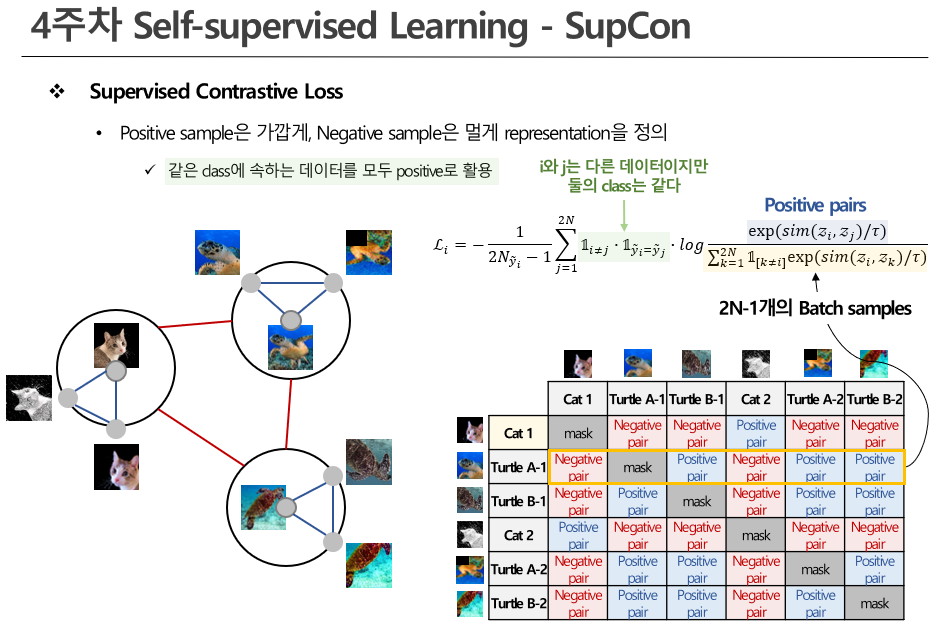

In [29]:
# Image('image/SupCon.PNG') # 로컬 사용시
Image('/content/2023_LG_ES_SSL_1/image/SupCon.PNG') # colab 사용시

In [23]:
def accuracy(output: torch.FloatTensor,
             target: torch.LongTensor,
             topk: tuple=(1, )):
    """
    Computes the accuracy over the top k predictions
    for the specified values of k
    - Top-1 Accuracy: softmax의 output에서 제일 높은 수치(confidence)를 가지는 확률 값이 실제 정답일 경우에 대한 지표 계산
    - Top-n Accuracy : softmax output 중 상위 n개의 확률 값을 가지는 클래스 중 실제 정답이 있는 경우에 대한 지표 계산
    """
    with torch.no_grad():
        max_k = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(max_k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        
        return res

In [18]:
class SupCon_Trainer(object):
    def __init__(self, device, model, **kwargs):
        self.device = device
        self.model = model.to(self.device)
        self.criterion = nn.CrossEntropyLoss().to(self.device)
        self.__dict__.update(kwargs)

    def supcon_loss(self, features: torch.FloatTensor, n_views: int=2,
                    labels: torch.LongTensor=None, mask: torch.Tensor=None):
        """
        Compute loss for model.
        If both 'labels' and 'mask' are None,
        it degenerates to SimCLR unsupervised loss
        : https://arxiv.org/pdf/2002.05709.pdf
        
        Args:
            features: hidden vector of shape [batch_size * n_views, ...].
            n_views: 2.
            labels: ground Truth of shape [batch_size].
            mask: contrastive mask of shape [batch_size, batch_size], mask_{i, j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both labels and mask.')
        
        elif labels is None and mask is None:
            mask = torch.eye(labels.size(0), dtype=torch.float32).to(self.device)

        elif labels is not None:
            # Define appropriate labels for n_views
            labels = torch.cat([labels, labels], dim=0)

            labels = labels.contiguous().view(-1, 1)

            if labels.shape[0] != len(labels):
                raise ValueError('Number of labels does not match number of features.')

            # torch.eq로 tensor 요소를 비교. label이 같으면 True(1), 다르면 False(0)
            mask = torch.eq(labels, labels.T).float().to(self.device) 
        else:
            mask = mask.float().to(self.device)

        # Mask-out self-contrast cases (diagonal이 0인 matrix)
        logits_mask = torch.scatter(
            torch.ones_like(mask), # Returns a tensor filled with the scalar value 1, with the same size as 'mask'
            dim=1,
            index=torch.arange(len(labels)).view(-1, 1).to(device=self.device), # 0부터 511까지의 값 -> index
            value=0)
        
        # Define mask based on same action labels except self-contrast cases
        mask = mask * logits_mask # diagonal part 0으로

        # Normalize feature vector
        features = F.normalize(features, dim=1)

        # Compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(features, features.T),  # Anchor dot Contrast
            self.temperature)

        # For numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # Compute log probability
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # Compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # Supervised Contrastive Loss (SCL)
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(n_views, int(len(labels) / 2)).mean()

        return loss
    
    def pretrain(self, train_loader):
        os.makedirs(self.ckpt_dir, exist_ok=True)  # create checkpoints directory
        
        n_iter = 0
        for epoch in range(self.epochs):
            
            train_loss = 0.0
            for images, labels in tqdm(train_loader):
                images = torch.cat(images, dim=0)  # 2 * Batch Size
                images = images.to(self.device)

                labels = labels.to(self.device)

                features = self.model(images)
                loss = self.supcon_loss(features=features, labels=labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss

                if n_iter % self.logging_steps == 0:
                    print(f'Loss: {loss} \n'
                          f'Learning Rate: {self.lr_scheduler.get_lr()[0]}')
                
                n_iter += 1

            train_loss /= (len(train_loader))

            # Warmup for the first 10 epochs
            if epoch >= 10:
                self.lr_scheduler.step()
                
            print('=' * 30)
            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {train_loss} \n'
                  f'Learning Rate: {self.lr_scheduler.get_lr()[0]}')
            
        # Save the model
        torch.save(self.model.encoder.state_dict(), os.path.join(self.ckpt_dir, 'pretrained_SupCon.pt'))

        return self.model   

## SupCon 코드 실행

In [24]:
def main(device, configs: dict):

    # define dataset, dataloader
    dataset = CIFAR10Dataset(data_dir=configs['data_dir'])   # local: './data/' or colab:'/content/2023_LG_ES_SSL_1/data/'

    train_dataset = dataset.get_pretrain_dataset(n_views=configs['n_views'])
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=True)
    
    # definde model, optimizer, learning rate scheduler
    model = ResNet(
        base_model=configs['backbone'],
        hidden_size=configs['hidden_size'],
        projection_size=configs['projection_size']
    )

    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(   # cosine annealing scheduler
        optimizer=optimizer,
        T_max=len(train_loader),
        eta_min=0,
        last_epoch=-1)

    trainer = SupCon_Trainer(
        model=model,
        device=device,
        optimizer=optimizer,
        lr_scheduler=lr_scheduler,
        batch_size = configs['batch_size'],
        epochs = configs['epochs'],
        logging_steps = configs['logging_steps'],
        ckpt_dir = configs['ckpt_dir'],
        temperature = configs['temperature'],
        base_temperature = configs['base_temperature']
        )
    
    pretrained_model = trainer.pretrain(train_loader=train_loader)

    return pretrained_model


if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    configs = {'data_dir': './data/',  # local: './data/' or colab:'/content/2023_LG_ES_SSL_1/data/'
               'ckpt_dir':'./ckpt_dir/SupCon', # local: './ckpt_dir/SimCLR' or colab:'/content/2023_LG_ES_SSL_1/ckpt_dir/SimCLR'
               'batch_size': 256, 'epochs': 5, 'logging_steps': 20,
               'temperature':0.1, 'base_temperature': 0.1,
               'learning_rate': 3e-4, 'weight_decay':1e-4,
               'backbone': 'resnet18', 'hidden_size': 512, 'projection_size': 128,
               'num_class': 10, 'n_views':2, 'num_worker': 0}
    
    pretrained_model = main(device, configs)


Files already downloaded and verified


  1%|          | 1/195 [00:00<02:53,  1.12it/s]

Loss: 6.430746078491211 
Learning Rate: 0.0003


 11%|█         | 21/195 [00:15<02:15,  1.29it/s]

Loss: 6.215349197387695 
Learning Rate: 0.0003


 21%|██        | 41/195 [00:30<01:59,  1.29it/s]

Loss: 6.168964385986328 
Learning Rate: 0.0003


 31%|███▏      | 61/195 [00:45<01:44,  1.28it/s]

Loss: 6.175839424133301 
Learning Rate: 0.0003


 42%|████▏     | 81/195 [01:00<01:22,  1.38it/s]

Loss: 6.173251152038574 
Learning Rate: 0.0003


 52%|█████▏    | 101/195 [01:14<01:08,  1.37it/s]

Loss: 6.163027763366699 
Learning Rate: 0.0003


 62%|██████▏   | 121/195 [01:29<00:58,  1.27it/s]

Loss: 6.170377254486084 
Learning Rate: 0.0003


 72%|███████▏  | 141/195 [01:44<00:41,  1.29it/s]

Loss: 6.118827819824219 
Learning Rate: 0.0003


 83%|████████▎ | 161/195 [01:58<00:24,  1.38it/s]

Loss: 6.122248649597168 
Learning Rate: 0.0003


 93%|█████████▎| 181/195 [02:13<00:10,  1.29it/s]

Loss: 6.145730972290039 
Learning Rate: 0.0003


100%|██████████| 195/195 [02:24<00:00,  1.35it/s]


Epoch: 1 
Loss: 6.169217586517334 
Learning Rate: 0.0003


  3%|▎         | 6/195 [00:04<02:27,  1.28it/s]

Loss: 6.118556022644043 
Learning Rate: 0.0003


 13%|█▎        | 26/195 [00:19<02:10,  1.30it/s]

Loss: 6.153592586517334 
Learning Rate: 0.0003


 24%|██▎       | 46/195 [00:34<01:49,  1.36it/s]

Loss: 6.1762495040893555 
Learning Rate: 0.0003


 34%|███▍      | 66/195 [00:48<01:34,  1.37it/s]

Loss: 6.1057658195495605 
Learning Rate: 0.0003


 44%|████▍     | 86/195 [01:03<01:24,  1.28it/s]

Loss: 6.118768692016602 
Learning Rate: 0.0003


 54%|█████▍    | 106/195 [01:18<01:05,  1.35it/s]

Loss: 6.142274856567383 
Learning Rate: 0.0003


 65%|██████▍   | 126/195 [01:33<00:53,  1.29it/s]

Loss: 6.11848258972168 
Learning Rate: 0.0003


 75%|███████▍  | 146/195 [01:48<00:36,  1.36it/s]

Loss: 6.110706329345703 
Learning Rate: 0.0003


 85%|████████▌ | 166/195 [02:02<00:20,  1.39it/s]

Loss: 6.100257873535156 
Learning Rate: 0.0003


 95%|█████████▌| 186/195 [02:17<00:06,  1.35it/s]

Loss: 6.135597229003906 
Learning Rate: 0.0003


100%|██████████| 195/195 [02:23<00:00,  1.36it/s]


Epoch: 2 
Loss: 6.126471519470215 
Learning Rate: 0.0003


  6%|▌         | 11/195 [00:07<02:12,  1.39it/s]

Loss: 6.12271785736084 
Learning Rate: 0.0003


 16%|█▌        | 31/195 [00:22<02:06,  1.29it/s]

Loss: 6.097171783447266 
Learning Rate: 0.0003


 26%|██▌       | 51/195 [00:37<01:45,  1.36it/s]

Loss: 6.057441711425781 
Learning Rate: 0.0003


 36%|███▋      | 71/195 [00:51<01:35,  1.30it/s]

Loss: 6.140384674072266 
Learning Rate: 0.0003


 47%|████▋     | 91/195 [01:06<01:15,  1.38it/s]

Loss: 6.088369369506836 
Learning Rate: 0.0003


 57%|█████▋    | 111/195 [01:21<01:01,  1.37it/s]

Loss: 6.1343841552734375 
Learning Rate: 0.0003


 67%|██████▋   | 131/195 [01:35<00:49,  1.30it/s]

Loss: 6.085035800933838 
Learning Rate: 0.0003


 77%|███████▋  | 151/195 [01:50<00:33,  1.30it/s]

Loss: 6.067655563354492 
Learning Rate: 0.0003


 88%|████████▊ | 171/195 [02:05<00:17,  1.40it/s]

Loss: 6.122799396514893 
Learning Rate: 0.0003


 98%|█████████▊| 191/195 [02:19<00:02,  1.38it/s]

Loss: 6.0999555587768555 
Learning Rate: 0.0003


100%|██████████| 195/195 [02:22<00:00,  1.37it/s]


Epoch: 3 
Loss: 6.103625774383545 
Learning Rate: 0.0003


  8%|▊         | 16/195 [00:11<02:17,  1.30it/s]

Loss: 6.099065780639648 
Learning Rate: 0.0003


 18%|█▊        | 36/195 [00:26<01:55,  1.37it/s]

Loss: 6.108017921447754 
Learning Rate: 0.0003


 29%|██▊       | 56/195 [00:40<01:42,  1.36it/s]

Loss: 6.157656669616699 
Learning Rate: 0.0003


 39%|███▉      | 76/195 [00:55<01:26,  1.38it/s]

Loss: 6.0507073402404785 
Learning Rate: 0.0003


 49%|████▉     | 96/195 [01:10<01:12,  1.36it/s]

Loss: 6.096512317657471 
Learning Rate: 0.0003


 59%|█████▉    | 116/195 [01:25<00:57,  1.37it/s]

Loss: 6.078077793121338 
Learning Rate: 0.0003


 70%|██████▉   | 136/195 [01:39<00:44,  1.33it/s]

Loss: 6.053024768829346 
Learning Rate: 0.0003


 80%|████████  | 156/195 [01:54<00:30,  1.29it/s]

Loss: 6.040557861328125 
Learning Rate: 0.0003


 90%|█████████ | 176/195 [02:09<00:14,  1.31it/s]

Loss: 6.05982780456543 
Learning Rate: 0.0003


100%|██████████| 195/195 [02:23<00:00,  1.36it/s]


Epoch: 4 
Loss: 6.087412357330322 
Learning Rate: 0.0003


  1%|          | 1/195 [00:00<02:19,  1.39it/s]

Loss: 6.09230899810791 
Learning Rate: 0.0003


 11%|█         | 21/195 [00:15<02:06,  1.37it/s]

Loss: 6.071469306945801 
Learning Rate: 0.0003


 21%|██        | 41/195 [00:29<01:52,  1.37it/s]

Loss: 6.111949920654297 
Learning Rate: 0.0003


 31%|███▏      | 61/195 [00:44<01:38,  1.36it/s]

Loss: 6.060314178466797 
Learning Rate: 0.0003


 42%|████▏     | 81/195 [00:59<01:22,  1.38it/s]

Loss: 6.009761810302734 
Learning Rate: 0.0003


 52%|█████▏    | 101/195 [01:14<01:11,  1.31it/s]

Loss: 6.078457832336426 
Learning Rate: 0.0003


 62%|██████▏   | 121/195 [01:28<00:57,  1.28it/s]

Loss: 6.031229019165039 
Learning Rate: 0.0003


 72%|███████▏  | 141/195 [01:43<00:38,  1.39it/s]

Loss: 6.051556587219238 
Learning Rate: 0.0003


 83%|████████▎ | 161/195 [01:57<00:25,  1.31it/s]

Loss: 6.033019542694092 
Learning Rate: 0.0003


 93%|█████████▎| 181/195 [02:12<00:10,  1.34it/s]

Loss: 6.09455680847168 
Learning Rate: 0.0003


100%|██████████| 195/195 [02:23<00:00,  1.36it/s]


Epoch: 5 
Loss: 6.065769195556641 
Learning Rate: 0.0003


## 사전학습 된 Encoder를 이용하여 Downstream Task 수행
- Transfer Learning(전이 학습)의 개념
- 사전학습 된 인코더를 활용하여 Supervised Learning 수행

In [25]:
class Downstream(object):
    def __init__(self, device, encoder, classifier, optimizer, **kwargs):
        self.device = device

        self.encoder = encoder.to(device)   # 사전학습 된 encoder 불러오기
        self.classifier = classifier.to(device)
        self.optimizer = optimizer

        self.criterion = nn.CrossEntropyLoss().to(device)
        self.__dict__.update(kwargs)

    def train_test(self, train_loader, test_loader):

        for epoch in range(self.epochs):
            # Train
            top1_train_acc, train_loss = 0, 0
            for i, (images, targets) in enumerate(train_loader):
                images = images.to(self.device)
                targets = targets.to(self.device)

                # Freeze Encoder Parameters (사전학습된 인코더의 파라미터는 업데이트 하지 않음)
                if self.downstream:
                    with torch.no_grad():
                        logits = self.encoder(images)
                        logits = logits.squeeze()
                else:
                    logits = self.encoder(images)
                    logits = logits.squeeze()

                logits = self.classifier(logits)
                loss = self.criterion(logits, targets)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                top1 = accuracy(logits, targets, topk=(1, ))
                top1_train_acc += top1[0]
                
                train_loss += loss

            top1_train_acc /= (i + 1)
            train_loss /= (i + 1)

            # Test
            top1_test_acc, top5_test_acc = 0, 0
            for i, (images, targets) in enumerate(test_loader):
                images = images.to(self.device)
                targets = targets.to(self.device)

                with torch.no_grad():
                    logits = self.encoder(images)
                    logits = logits.squeeze()
                    logits = self.classifier(logits)

                top1, top5 = accuracy(logits, targets, topk=(1, 5))
                top1_test_acc += top1[0]
                top5_test_acc += top5[0]

            top1_test_acc /= (i + 1)
            top5_test_acc /= (i + 1)

            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {train_loss} \n'
                  f'Top1 Train Accuracy: {top1_train_acc.item()} \n'
                  f'Top1 Test Accuracy: {top1_test_acc.item()} \n'
                  f'Top5 Test Accuracy: {top5_test_acc.item()} \n')
        
        return self.encoder, self.classifier

In [26]:
def main(device, configs: dict):
    
    # Define Dataset, Dataloader   
    Cifar10_dataset = CIFAR10Dataset(data_dir=configs['data_dir'])  # local: './data/' or colab:'/content/2023_LG_ES_SSL_1/data/'
    
    train_dataset = Cifar10_dataset.get_dataset(mode='train')
    test_dataset = Cifar10_dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    # Define encoder, optimizer, linear classifier
        # load pretrained encoder
    encoder = ResNet(
                    base_model=configs['backbone'],
                    hidden_size=configs['hidden_size'],
                    projection_size=configs['projection_size']
                    ).encoder
    encoder.load_state_dict(torch.load(os.path.join(configs['ckpt_dir'], 'pretrained_SupCon.pt')))
    print("All keys matched successfully")

    classifier = nn.Linear(512, configs['num_class'])

    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    downstream = Downstream(
        device = device,
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream = configs['downstream'])
    
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
    configs = {'data_dir': './data/',          # local: './data/' or colab:'/content/2023_LG_ES_SSL_1/data/'
               'ckpt_dir':'./ckpt_dir/SupCon', # local: './ckpt_dir/SimCLR' or colab:'/content/2023_LG_ES_SSL_1/ckpt_dir/SimCLR'
               'downstream': True, 'batch_size': 256, 'epochs': 10, 
               'learning_rate': 3e-4, 'weight_decay':1e-4,
               'backbone': 'resnet18', 'hidden_size': 512, 'projection_size': 128,
               'num_class': 10, 'num_worker': 0}
    supervised_model = main(device, configs)

Files already downloaded and verified
Files already downloaded and verified
All keys matched successfully
Epoch: 1 
Loss: 1.4394311904907227 
Top1 Train Accuracy: 47.68136215209961 
Top1 Test Accuracy: 51.279296875 
Top5 Test Accuracy: 93.88671875 

Epoch: 2 
Loss: 1.3020284175872803 
Top1 Train Accuracy: 52.17354965209961 
Top1 Test Accuracy: 52.05078125 
Top5 Test Accuracy: 94.365234375 

Epoch: 3 
Loss: 1.2860262393951416 
Top1 Train Accuracy: 52.768653869628906 
Top1 Test Accuracy: 52.71484375 
Top5 Test Accuracy: 94.658203125 

Epoch: 4 
Loss: 1.2759021520614624 
Top1 Train Accuracy: 53.1385498046875 
Top1 Test Accuracy: 52.91015625 
Top5 Test Accuracy: 94.619140625 

Epoch: 5 
Loss: 1.2693325281143188 
Top1 Train Accuracy: 53.333065032958984 
Top1 Test Accuracy: 53.564453125 
Top5 Test Accuracy: 94.66796875 

Epoch: 6 
Loss: 1.2616270780563354 
Top1 Train Accuracy: 53.672672271728516 
Top1 Test Accuracy: 53.26171875 
Top5 Test Accuracy: 94.84375 

Epoch: 7 
Loss: 1.25480890274047

-------

## [비교] SupCon으로 사전학습을 수행하지 않고, 단순히 지도학습(Supervised Learning)을 수행한 경우
- supcon loss를 적용하지 않고 cross-entropy loss로 지도학습을 수행한 경우

In [27]:
def main(device, configs: dict):
    
    # Define Dataset, Dataloader   
    Cifar10_dataset = CIFAR10Dataset(data_dir=configs['data_dir'])  # local: './data/' or colab:'/content/2023_LG_ES_SSL_1/data/'
    
    train_dataset = Cifar10_dataset.get_dataset(mode='train')
    test_dataset = Cifar10_dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    # Define encoder, optimizer, linear classifier
    encoder = ResNet(
        base_model=configs['backbone'],
        hidden_size=configs['hidden_size'],
        projection_size=configs['projection_size']
    ).encoder
    
    classifier = nn.Linear(512, configs['num_class'])

    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    downstream = Downstream(
        device = device,
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream = configs['downstream'])
    
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
    configs = {'data_dir': '/content/2023_LG_ES_SSL_1/data/',  # local: './data/' or colab:'/content/2023_LG_ES_SSL_1/data/'
               'downstream': False, 'batch_size': 256, 'epochs': 10,
               'learning_rate': 3e-4, 'weight_decay':1e-4,
               'backbone': 'resnet18', 'hidden_size': 512, 'projection_size': 128,
               'num_class': 10, 'num_worker': 0}
    supervised_model = main(device, configs)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 
Loss: 2.2212491035461426 
Top1 Train Accuracy: 18.96484375 
Top1 Test Accuracy: 24.94140625 
Top5 Test Accuracy: 74.462890625 

Epoch: 2 
Loss: 2.0405313968658447 
Top1 Train Accuracy: 26.715959548950195 
Top1 Test Accuracy: 28.212890625 
Top5 Test Accuracy: 77.5390625 

Epoch: 3 
Loss: 1.9766621589660645 
Top1 Train Accuracy: 29.587053298950195 
Top1 Test Accuracy: 29.228515625 
Top5 Test Accuracy: 79.169921875 

Epoch: 4 
Loss: 1.9408531188964844 
Top1 Train Accuracy: 30.948261260986328 
Top1 Test Accuracy: 30.0390625 
Top5 Test Accuracy: 80.107421875 

Epoch: 5 
Loss: 1.919872522354126 
Top1 Train Accuracy: 31.90888023376465 
Top1 Test Accuracy: 30.869140625 
Top5 Test Accuracy: 80.341796875 

Epoch: 6 
Loss: 1.9048131704330444 
Top1 Train Accuracy: 32.45814514160156 
Top1 Test Accuracy: 31.015625 
Top5 Test Accuracy: 80.7421875 

Epoch: 7 
Loss: 1.8953938484191895 
Top1 Train Accuracy: 33.00860977

-----------

### 성능 비교

|   | Supervised Learning | Supervised Contrastive Learning | 
|---| ------------------- | ----------- | 
|Top 1 Train ACC| 33.74 | 54.20 | 
|Top 1 Test ACC| 31.69 | 54.07 | 
|Top 5 Test ACC| 81.02 | 94.98 | 